# Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

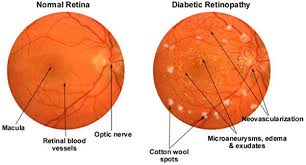

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes this [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite well-characterized. 

# A look at the data:

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

...

> Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

**A minor problem!**

Due to the large image file size, there are **only 1000 files with labels** and one csv file with the labels of all the images in the directory available in the kernel, as demonstrated below. The actual competition had on the order of 35,000 files so this is clearly **a very small subset of the data**. 
In addition, this is a highly imbalanced dataset. 

Originally, I had aimed to create a model that would be close to the SOTA, but clearly, with only 1000 images that's not possible.

**AIM OF KERNEL:** I will utilize transfer learning, oversampling, and progressive resizing on this small, imbalanced dataset.
Given that many real-world datasets are also small and imbalanced, it will be interesting to see how far these techniques will take us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [2]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         


## Importing labels

In [3]:
import pandas as pd

trainLabels = pd.read_csv("./trainLabels.csv")

In [4]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y # restrict extracted file to about 100 for the disk restriction
!mkdir data
!mv train data/train_11





The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 1545 kB of archives.
After this operation, 5896 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip amd64 16.02+dfsg-7build1 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip-full amd64 16.02+dfsg-7build1 [1187 kB]
Fetched 1545 kB in 0s (5825 kB/s)

78Selecting previously unselected package p7zip.
(Reading database ... 103272 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-7build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 11%] [######....................................................] 8Unpacking p7zip (16.02+dfsg-7build1) ...
7Progress: [ 22%] [############........

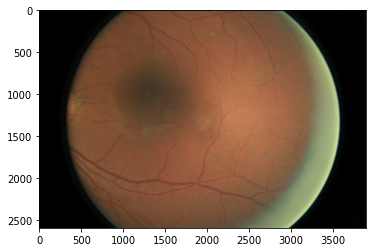

In [5]:
from PIL import Image

img = Image.open("./data/train_11/1116_right.jpeg")

import matplotlib.pyplot as plt

plt.imshow(img)

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Filtering csv file

In [7]:
import os
base_image_dir = os.path.join('.', 'data/train_11')
df = pd.read_csv(os.path.join('./trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

,level,path
0,3,./data/train_11/11871_left.jpeg
1,2,./data/train_11/11975_left.jpeg
2,3,./data/train_11/11734_left.jpeg
3,0,./data/train_11/11049_right.jpeg
4,2,./data/train_11/11054_right.jpeg
5,4,./data/train_11/1138_left.jpeg
6,0,./data/train_11/11894_right.jpeg
7,0,./data/train_11/11234_right.jpeg
8,0,./data/train_11/11749_right.jpeg
9,0,./data/train_11/11079_left.jpeg


### The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.


<AxesSubplot:>

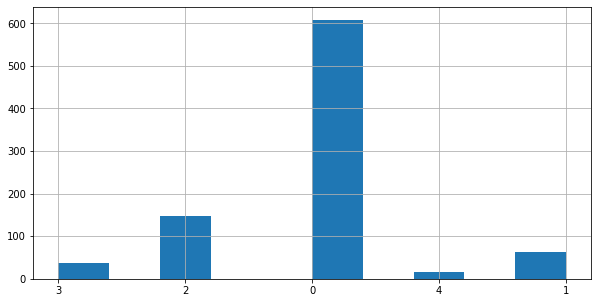

In [8]:
df['level'].hist(figsize = (10, 5))

In [9]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df


175

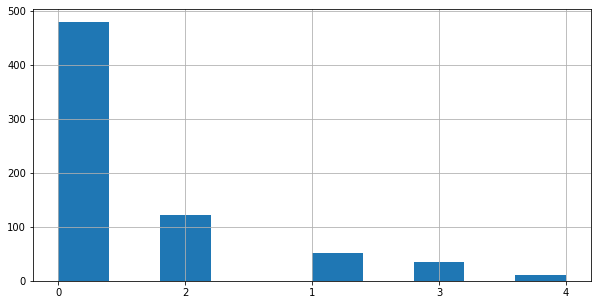

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

New Data Size: 2400 Old Size: 697


<AxesSubplot:>

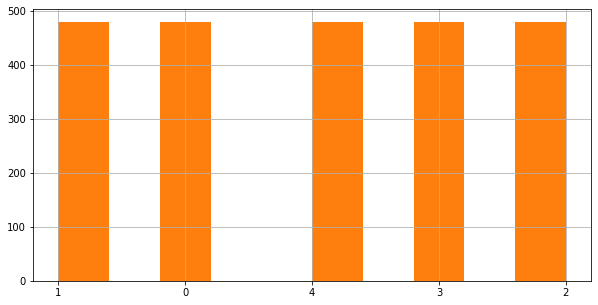

In [11]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [12]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

2575

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [14]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 2400 validated image filenames belonging to 5 classes.
Found 175 validated image filenames belonging to 5 classes.


In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Image Data Generator

In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
t_x, t_y = next(x_train)


## Showing some pics

In [18]:
# plt.figure(figsize=(10, 10))
# for images, labels in x_train.take(1):
#   for i in range(6):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(classnames[labels[i]])
#     plt.axis("off")

## CNN Models

In [19]:
def create_CNN_model(model):
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

In [20]:
# def create_models(model_type):
#     model = Sequential()
#     if (model_type=="cnn"):
#         create_CNN_model(model)
#     elif(model_type == "resnet"):
#         pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(256,256,3),
#                    pooling='avg',classes=5,
#                    weights='imagenet')
#         for layer in pretrained_model.layers:
#                 layer.trainable=False

#         model.add(pretrained_model)
#     elif(model_type == "googlenet"):
#         pretrained_model = tf.keras.applications.InceptionV3(
#                     include_top=True,
#                     weights="imagenet",
#                     input_shape=(299,299,3),
#                     pooling='avg',
#                     classes=1000)
#         for layer in pretrained_model.layers:
#                 layer.trainable=False
#         model.add(pretrained_model)
        
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(5, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer=Adam(learning_rate=0.002),
#                   metrics=['accuracy',"AUC"])
#     return model;

from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
_____________________________

In [21]:
# model = create_models("googlenet")

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

## Callbacks for Parameter Tuning

In [23]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [24]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=50,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model.save_weights("dr_messidor.h5")


Epoch 1/50
37/37 [==============================] - 193s 5s/step - loss: 1.1621 - categorical_accuracy: 0.5270 - top_2_accuracy: 0.7466 - val_loss: 2.3683 - val_categorical_accuracy: 0.0938 - val_top_2_accuracy: 0.2969
Epoch 2/50
37/37 [==============================] - 186s 5s/step - loss: 0.7865 - categorical_accuracy: 0.6841 - top_2_accuracy: 0.8666 - val_loss: 1.8130 - val_categorical_accuracy: 0.2188 - val_top_2_accuracy: 0.4844
Epoch 3/50
37/37 [==============================] - 189s 5s/step - loss: 0.6179 - categorical_accuracy: 0.7542 - top_2_accuracy: 0.9147 - val_loss: 1.5669 - val_categorical_accuracy: 0.3281 - val_top_2_accuracy: 0.6406
Epoch 4/50
37/37 [==============================] - 186s 5s/step - loss: 0.5342 - categorical_accuracy: 0.7779 - top_2_accuracy: 0.9383 - val_loss: 1.2414 - val_categorical_accuracy: 0.4688 - val_top_2_accuracy: 0.8125
Epoch 5/50
37/37 [==============================] - 188s 5s/step - loss: 0.4903 - categorical_accuracy: 0.8167 - top_2_accur

In [25]:
# Evaluate on training and test data
train_results = model.evaluate(x_train, verbose=1)
test_results = model.evaluate(x_test, verbose=1)

# Extract the loss and accuracy values
train_loss = train_results[0]
train_accu = train_results[1]
test_loss = test_results[0]
test_accu = test_results[1]

# Print results
print("Final training accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
print("Final training loss = {:.2f} , validation loss = {:.2f}".format(train_loss, test_loss))


6/6 [==============================] - 23s 4s/step - loss: 1.1467 - categorical_accuracy: 0.6343 - top_2_accuracy: 0.8971
Final training accuracy = 94.79 , validation accuracy = 63.43
Final training loss = 0.15 , validation loss = 1.15


In [26]:
history.history
print(history.history.keys())


dict_keys(['loss', 'categorical_accuracy', 'top_2_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_top_2_accuracy', 'lr'])


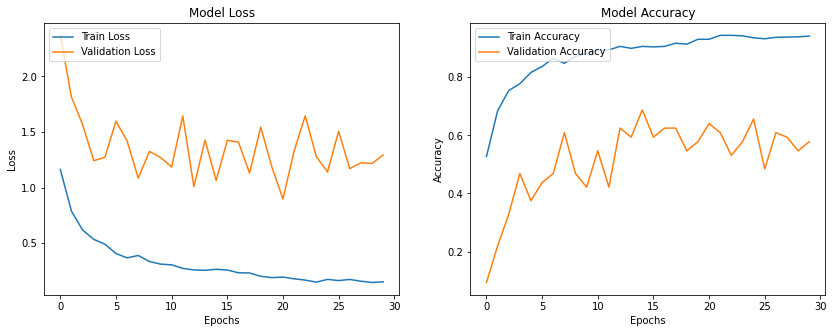

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


Confusion Matrix
[[ 94  99  94  93 100]
 [106  95  86 100  93]
 [ 90 106  94  87 103]
 [ 96  93  91 101  99]
 [124  88  79 102  87]]
Classification Report
              precision    recall  f1-score   support

           0       0.18      0.20      0.19       480
           1       0.20      0.20      0.20       480
           2       0.21      0.20      0.20       480
           3       0.21      0.21      0.21       480
           4       0.18      0.18      0.18       480

    accuracy                           0.20      2400
   macro avg       0.20      0.20      0.20      2400
weighted avg       0.20      0.20      0.20      2400



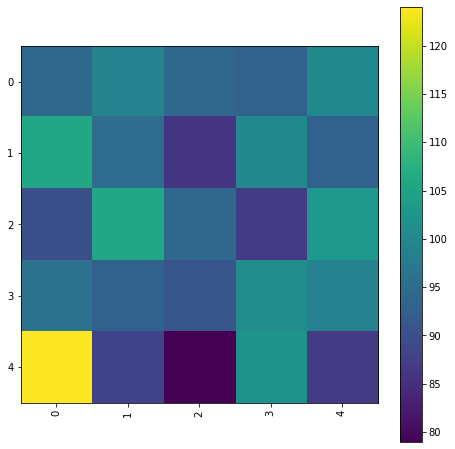

In [28]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = x_test.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(x_train.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(x_train.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)